
# 🌧️ RAIL: Indigenous Weather Forecasting

The task is to build a classification model that predicts the type of rainfall—heavy, moderate, or small—expected in the next 12 to 24 hours, based solely on indigenous ecological indicators submitted by trained farmers.

Model question: Given the farmer’s predicted intensity guess + confidence, which of the 4 rainfall categories is most likely?
* predicted_intensity: continious {0.00, 0.33, 0.66, 1.00}
* confidence: continious {0.0, 0.3, 0.6, 1.0}
* Target: categorical {NORAIN, SMALLRAIN, MEDIUMRAIN, HEAVYRAIN}

The data for this challenge was collected using the Smart Indigenous Weather App, a custom-built mobile app for data collection, available on the Google Play Store. Data was collected from local farmers in the Pra River Basin of Ghana.

Key steps in data collection included:
* Rain Gauge Deployment: Calibrated garden rain gauges were installed on the properties of 25 local farmers across three regions (Central, Eastern, and Ashanti).
* Farmer Training: Farmers were trained to record daily rainfall observations and to submit their indigenous weather and climate forecasts using the Smart Indigenous Weather App.
* Use of Indigenous Ecological Indicators (IEIs): Farmers made forecasts based on traditional signs such as cloud formations, sun position, wind, moon, heat, and specific tree or animal behaviors.

The following variables were and continue to be collected are:
* Daily rainfall amounts (measured using the rain gauges.
* Forecast type (e.g., prediction of heavy, medium, small, or no rainfall)
* Ecological indicators used (e.g., cloud, sun, moon, heat, wind)
* Prediction time frame (12-hour and 24-hour forecasts)
* Accuracy of prediction (hit/miss rate, compared with actual rainfall)

The objective of this challenge is to predict the type of rain to be expected in the next 12 to 24 hours.


## Set-up

In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.base import clone

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

import shap
import scipy.sparse as sp
from scipy.stats import spearmanr

import optuna
import optuna.visualization as vis

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Paths
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
SAMPLE_SUB_PATH = "SampleSubmission.csv"

assert os.path.exists(TRAIN_PATH), f"Missing: {TRAIN_PATH}"
assert os.path.exists(TEST_PATH), f"Missing: {TEST_PATH}"
assert os.path.exists(SAMPLE_SUB_PATH), f"Missing: {SAMPLE_SUB_PATH}"

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("SampleSubmission columns:", list(sample_sub.columns))
display(sample_sub.head())

# Inspect columns
train.head()

Train shape: (10928, 12)
Test shape: (2732, 11)
SampleSubmission columns: ['ID', 'Target']


,ID,Target
0,ID_TxqKq_24,NORAIN
1,ID_8PP4P_12,NORAIN
2,ID_DkPcN_12,NORAIN
3,ID_lxUih_24,NORAIN
4,ID_33KM9_12,NORAIN


,ID,user_id,confidence,predicted_intensity,community,district,prediction_time,indicator,indicator_description,time_observed,Target,forecast_length
0,ID_KwcTp_12,11,0.3,0.0,Tumfa,atiwa_west,2025-05-30 11:09:33,NaN,NaN,NaN,MEDIUMRAIN,12
1,ID_K9vWT_12,17,0.3,0.0,Kwabeng,atiwa_west,2025-05-30 11:09:35,NaN,NaN,NaN,HEAVYRAIN,12
2,ID_AIQg3_12,19,0.3,0.0,Akropong,atiwa_west,2025-05-30 11:09:47,NaN,NaN,NaN,MEDIUMRAIN,12
3,ID_px4yf_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:33,NaN,NaN,NaN,HEAVYRAIN,12
4,ID_QYYmK_12,23,0.3,0.0,Asamama,atiwa_west,2025-05-30 11:16:55,NaN,NaN,NaN,HEAVYRAIN,12


In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10928 entries, 0 to 10927
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     10928 non-null  object 
 1   user_id                10928 non-null  int64  
 2   confidence             10928 non-null  float64
 3   predicted_intensity    10928 non-null  float64
 4   community              10928 non-null  object 
 5   district               10928 non-null  object 
 6   prediction_time        10928 non-null  object 
 7   indicator              503 non-null    object 
 8   indicator_description  346 non-null    object 
 9   time_observed          72 non-null     object 
 10  Target                 10928 non-null  object 
 11  forecast_length        10928 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 1.0+ MB


# Feature Engineering

Note. The features themselves are guesses, and when they’re wrong, they may look misleading to the model.

## Contextual features

day_index:
The dataset is only 2 months long, therefore numbering days sequentially (like a timeline) is more relevant than breaking them into calendar-based categories.
* day_index = 1, 2, 3, …, N -> This tells the model that later days are further from earlier days and does not reset each month.

time_index: 
Cyclical encoding makes 23:00 and 00:00 neighbours in the feature space, otherwise they're considered far apart.
A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.


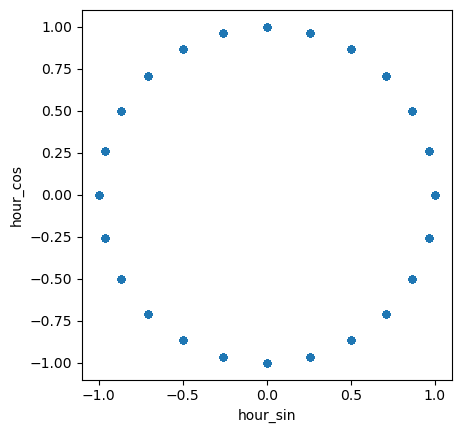

In [48]:
def build_time_features(df, time_col="prediction_time", ref_start=None, keep_cols=False):
    """
    Create day_index and cyclical hour features from a datetime column.
    """
    df_out = df.copy()

    # Parse datetime
    ts = pd.to_datetime(df_out[time_col], errors="coerce")

    # Establish a start 
    if ref_start is None:
        ref_start = ts.min().normalize()  # start-of-day of earliest timestamp
    ref_start = pd.to_datetime(ref_start).normalize()

    # Core components
    hour = ts.dt.hour
    day_index = (ts.dt.normalize() - ref_start).dt.days + 1

    # Cyclical encodings for hour of day
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)

    feats = pd.DataFrame({
        "day_index": day_index,
        "hour_sin": hour_sin,
        "hour_cos": hour_cos,
    }, index=df_out.index)

    if keep_cols:
        df_out = pd.concat([df_out, feats], axis=1)
    else:
        df_out = feats

    return df_out, ref_start

# Apply
train, ref_start = build_time_features(train, time_col="prediction_time", ref_start=None, keep_cols=True)
test, _ = build_time_features(test, time_col="prediction_time", ref_start=ref_start, keep_cols=True)

ax = train.plot.scatter('hour_sin', 'hour_cos').set_aspect('equal')

In [49]:
def clean_communities(df, col="community"):
    """
    Clean community names in a dataframe by normalising case, 
    stripping whitespace, applying manual replacements, 
    and converting to snake_case for consistency.
    """
    df_clean = df.copy()

    # Normalise to lowercase & strip whitespace
    df_clean[col] = df_clean[col].str.strip().str.lower()

    # Manual replacements
    replace_map = {
        "akwaduuso": "Akwaduuso",
        "akwaduuso ": "Akwaduuso",
        "akropong": "Akropong",
        "assinn yAnkomasi".lower(): "Assin Nyankomasi",
        "assin nyankomasi": "Assin Nyankomasi",
        "assin atonsu": "Assin Atonsu",
        "atonsu": "Assin Atonsu",
        "assin  atonsu": "Assin Atonsu",
        "assin aponsie": "Assin Aponsie",
        "assin  aponsie": "Assin Aponsie",
        "odumasi": "Foso Odumasi",
        "foso odumasi": "Foso Odumasi",
        "assin foso odumasi": "Foso Odumasi",
        "odumasi  adansi": "Foso Odumasi",
        "mouso": "Abomosu",
        "asunafo": "Asunafo",
        "apampatia": "Apampatia",
        "assin brofoyedur": "Assin Brofoyedur",
        "assin wurakese": "Assin Wurakese",
        "assin mesre nyame": "Assin Mesre Nyame",
        "amonon": "Amonom",
        "tumfa": "Tumfa",
        "awenare": "Awenare",
        "mampamhwe": "Mampamhwe",
        "banso": "Banso",
        "asamama": "Asamama"
    }
    df_clean[col] = df_clean[col].replace(replace_map)

    # Convert to snake_case for consistency
    df_clean[col] = df_clean[col].str.strip().str.lower().str.replace(" ", "_")

    # Print summary
    print("Unique communities:", df_clean[col].nunique())
    print(df_clean[col].value_counts())

    return df_clean

train = clean_communities(train, col="community")
test = clean_communities(test, col="community")

Unique communities: 19
community
foso_odumasi         2127
akwaduuso            1681
asamama              1139
akropong             1077
assin_nyankomasi      876
tumfa                 624
assin_atonsu          597
abomosu               557
kwabeng               521
awenare               457
mampamhwe             387
assin_brofoyedur      219
assin_aponsie         182
banso                 148
asunafo               116
amonom                 96
apampatia              56
assin_wurakese         34
assin_mesre_nyame      34
Name: count, dtype: int64
Unique communities: 21
community
akwaduuso           774
foso_odumasi        482
assin_brofoyedur    287
asamama             199
akropong            197
tumfa               164
mampamhwe           125
awenare              76
banso                76
asunafo              51
kwabeng              51
assin_atonsu         49
abomosu              49
assin_aponsie        41
assin_wurakese       32
assin_nyankomasi     23
asonkore             20
jimiso

Deciding whether to include user id in the features. Here we see a high overlap of users between the train and test sets. Since the same farmers are present in both splits, the model can legitimately learn individual farmer skill levels. The current test is mostly a seen-user evaluation.

As there is high overlap between train and test users the model might learn that some users are better predictors than others based on their experience. Let's add an experience feature (logged and weighted based on confidence) and see how it influences the model.

In [50]:
train = train.copy()
test  = test.copy()

train["prediction_time"] = pd.to_datetime(train["prediction_time"])
test["prediction_time"]  = pd.to_datetime(test["prediction_time"])

train["user_id"] = train["user_id"].astype(str)
test["user_id"]  = test["user_id"].astype(str)

# TRAIN experience (no leakage)
train = train.sort_values(["user_id", "prediction_time"], kind="mergesort")
train["experience"] = train.groupby("user_id").cumcount()

# TEST experience
#    prior TRAIN rows + earlier TEST rows (same user)

# helper: per-user searchsorted against TRAIN times
prior_from_train = np.zeros(len(test), dtype=int)
# we'll also build earlier-within-test counts
within_test = np.zeros(len(test), dtype=int)

# work on a sorted view of test to compute within-user cumcount
test_sorted = test.sort_values(["user_id", "prediction_time"], kind="mergesort")
within_test_sorted = test_sorted.groupby("user_id").cumcount().to_numpy()

# map back positions later
rev_index = pd.Series(np.arange(len(test_sorted)), index=test_sorted.index)

# iterate users present in test
for uid, g_test in test_sorted.groupby("user_id"):
    # TRAIN times for this user (sorted)
    tt = train.loc[train["user_id"] == uid, "prediction_time"].to_numpy()
    # TEST times for this user (sorted, aligned to g_test)
    qt = g_test["prediction_time"].to_numpy()

    if tt.size == 0:
        # no prior train rows for this user
        counts = np.zeros(qt.shape[0], dtype=int)
    else:
        # STRICTLY earlier train rows:
        counts = np.searchsorted(tt, qt, side="left")

    # write into the aligned positions in the sorted test order
    prior_from_train[rev_index.loc[g_test.index].to_numpy()] = counts

# total test experience = prior train + earlier test rows
test_sorted["experience"] = prior_from_train + within_test_sorted

# restore original test row order
test = test.loc[test_sorted.index].copy()
test["experience"] = test_sorted["experience"].to_numpy()

# 3) Derived features (both splits)
for df in (train, test):
    df["exp_log"]  = np.log1p(df["experience"])
    df["exp_conf"] = df["exp_log"] * df["confidence"]


exp_log vs hit: ρ = +0.079 → tiny but consistently positive. Experience alone helps a bit.

exp_conf vs hit: ρ = +0.209 → the combo “more experienced × more confident” correlates meaningfully with correctness. This is the one to keep.

**Making user-id categorical so that it can be encoded**

In [51]:
# Train: cast to categorical
train["user_id"] = train["user_id"].astype(str).astype("category")

# Test: cast and align categories to train (prevents category mismatches)
test["user_id"] = test["user_id"].astype(str)
test["user_id"] = test["user_id"].astype(
    pd.CategoricalDtype(categories=train["user_id"].cat.categories)
)

## Prediction features

Applying the same categorical coding for predicted intensity to the target variable.

In [52]:
# Numerically encoding target
target_map = {"NORAIN": 0, "SMALLRAIN": 1, "MEDIUMRAIN": 2, "HEAVYRAIN": 3}
train["target_num"] = train["Target"].map(target_map).astype(int)

# Interaction terms: intensity and confidence
train["weighted_pred"] = train["predicted_intensity"] * train["confidence"]
train["intensity_poly2"] = train["predicted_intensity"]**2
train["confidence_poly2"] = train["confidence"]**2

test["weighted_pred"] = test["predicted_intensity"] * test["confidence"]
test["intensity_poly2"] = test["predicted_intensity"]**2
test["confidence_poly2"] = test["confidence"]**2

# Binary indicator for whether the prediction is for further in time
train["is_24h"] = (train["forecast_length"] == 24).astype("int8")

test["is_24h"] = (test["forecast_length"] == 24).astype("int8")

# Binary indicator for whether a reason is give for prediction
train["has_reason"] = train["indicator"].notna().astype(int)
test["has_reason"] = test["indicator"].notna().astype(int)

Ensuring that all train features also exist for the test set.

In [53]:
all_cols = ["user_id", "district","community", "predicted_intensity","confidence", "weighted_pred","exp_log","exp_conf","hour_sin","hour_cos","day_index","is_24h","has_reason"]

required = set(all_cols)
assert required.issubset(set(test.columns)), f"Test missing: {required - set(test.columns)}"


# Modelling

## Baseline

Predicting all 'NORAIN'

In [9]:
y = train["target_num"].astype(int).copy()

f1_score(y, np.zeros_like(y), average='macro')

0.23398247322297955

## XGBoost

**Preparing the data for modelling**

In [10]:
# Define features based on dtypes
cat_cols = ["user_id", "district","community"]
num_core_poly = ["predicted_intensity","confidence"]
num_plain_cols = ["weighted_pred","exp_log","exp_conf","hour_sin","hour_cos","day_index","is_24h","has_reason"]

# ensure no duplicates between lists
assert not (set(num_core_poly) & set(num_plain_cols)), "dup between core_poly and plain"
all_cols = cat_cols + num_core_poly + num_plain_cols
assert len(all_cols) == len(set(all_cols)), "duplicate names in all_cols"

# Build X and y
df = train.copy()
for c in cat_cols:
    df[c] = df[c].astype("category").astype("str")

X = df[all_cols].copy()
y = df["target_num"].astype(int).copy()

# guard: all columns exist
missing = [c for c in all_cols if c not in X.columns]
assert not missing, f"Missing in X: {missing}"

# Build preprocessor for pipeline
num_poly = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(2, include_bias=False)),
])
num_plain = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

preprocess = ColumnTransformer([
    ("num_poly",  num_poly,  num_core_poly),
    ("num_plain", num_plain, num_plain_cols),
    ("cat",       OneHotEncoder(handle_unknown="ignore"), cat_cols),
], remainder="drop")


**Finding the best params w/ Optuna**

We keep the preprocessing inside the pipeline to avoide dataleakage.

In [11]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average="macro")

def objective(trial: optuna.Trial) -> float:
    try:
        params = {
            "objective": "multi:softprob",
            "num_class": 4,
            "tree_method": "hist",
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
            "n_estimators": trial.suggest_int("n_estimators", 300, 3000),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0),
            "n_jobs": 1,
            "random_state": 42,
            "verbosity": 0,
        }

        model = XGBClassifier(**params)
        pipe = Pipeline([("prep", preprocess), ("clf", model)])

        scores = cross_val_score(pipe, X, y, cv=skf, scoring=scorer, n_jobs=-1)
        val = float(np.mean(scores))

        if not np.isfinite(val):
            trial.set_user_attr("error", "Non-finite score")
            raise ValueError("Non-finite score")

        return val

    except Exception as e:
        trial.set_user_attr("exception", repr(e))
        return float("nan")

study = optuna.create_study(direction="maximize", study_name="xgb_macro_f1")
study.optimize(objective, n_trials=30, show_progress_bar=True, gc_after_trial=True)

print("Best score:", study.best_value)
print("Best params:", study.best_params)

[I 2025-10-15 17:43:27,993] A new study created in memory with name: xgb_macro_f1
  0%|          | 0/30 [00:06<?, ?it/s]

[I 2025-10-15 17:43:34,425] Trial 0 finished with value: 0.853985974824979 and parameters: {'max_depth': 3, 'learning_rate': 0.020138839983483165, 'n_estimators': 2289, 'subsample': 0.5635629538065814, 'colsample_bytree': 0.740290071308558, 'min_child_weight': 10, 'gamma': 1.9331223886398219, 'reg_alpha': 1.6927387387641093, 'reg_lambda': 1.5632472874051504}. Best is trial 0 with value: 0.853985974824979.


Best trial: 1. Best value: 0.927852:   7%|▋         | 2/30 [00:10<02:13,  4.78s/it]

[I 2025-10-15 17:43:38,006] Trial 1 finished with value: 0.9278518233910923 and parameters: {'max_depth': 10, 'learning_rate': 0.06668321058177457, 'n_estimators': 837, 'subsample': 0.9049169662491345, 'colsample_bytree': 0.5541959919004854, 'min_child_weight': 5, 'gamma': 0.40887270714044854, 'reg_alpha': 1.8164952302145598, 'reg_lambda': 0.8900948024117199}. Best is trial 1 with value: 0.9278518233910923.


Best trial: 1. Best value: 0.927852:  10%|█         | 3/30 [00:13<01:48,  4.01s/it]

[I 2025-10-15 17:43:41,135] Trial 2 finished with value: 0.8859140683195783 and parameters: {'max_depth': 5, 'learning_rate': 0.08986903756400574, 'n_estimators': 2490, 'subsample': 0.8036238550634871, 'colsample_bytree': 0.7372500204195342, 'min_child_weight': 4, 'gamma': 3.5198349244131526, 'reg_alpha': 0.7397218738748619, 'reg_lambda': 4.652635871244974}. Best is trial 1 with value: 0.9278518233910923.


Best trial: 1. Best value: 0.927852:  13%|█▎        | 4/30 [00:17<01:44,  4.03s/it]

[I 2025-10-15 17:43:45,121] Trial 3 finished with value: 0.9047873423399244 and parameters: {'max_depth': 9, 'learning_rate': 0.07102844874564988, 'n_estimators': 2527, 'subsample': 0.8212748804250047, 'colsample_bytree': 0.888246043165442, 'min_child_weight': 2, 'gamma': 2.958930353187693, 'reg_alpha': 1.0738777116368101, 'reg_lambda': 4.730043409393062}. Best is trial 1 with value: 0.9278518233910923.


Best trial: 1. Best value: 0.927852:  17%|█▋        | 5/30 [00:20<01:37,  3.89s/it]

[I 2025-10-15 17:43:48,816] Trial 4 finished with value: 0.8748260978773885 and parameters: {'max_depth': 3, 'learning_rate': 0.03497151943634915, 'n_estimators': 2793, 'subsample': 0.9573690979184668, 'colsample_bytree': 0.6498516255377758, 'min_child_weight': 3, 'gamma': 3.3034085180650785, 'reg_alpha': 0.2009662660707492, 'reg_lambda': 2.818288140394671}. Best is trial 1 with value: 0.9278518233910923.


Best trial: 1. Best value: 0.927852:  20%|██        | 6/30 [00:24<01:33,  3.91s/it]

[I 2025-10-15 17:43:52,757] Trial 5 finished with value: 0.8536898771223494 and parameters: {'max_depth': 9, 'learning_rate': 0.09981730981037365, 'n_estimators': 2362, 'subsample': 0.6160301428772689, 'colsample_bytree': 0.8465462787538909, 'min_child_weight': 2, 'gamma': 4.644825593346834, 'reg_alpha': 1.5516321345206672, 'reg_lambda': 2.009807198397461}. Best is trial 1 with value: 0.9278518233910923.


Best trial: 1. Best value: 0.927852:  23%|██▎       | 7/30 [00:26<01:14,  3.23s/it]

[I 2025-10-15 17:43:54,654] Trial 6 finished with value: 0.8927603123391012 and parameters: {'max_depth': 10, 'learning_rate': 0.024169307509425832, 'n_estimators': 1408, 'subsample': 0.9920188627575939, 'colsample_bytree': 0.8439157648841168, 'min_child_weight': 5, 'gamma': 3.490916389817534, 'reg_alpha': 1.8322604024694331, 'reg_lambda': 1.162334449310455}. Best is trial 1 with value: 0.9278518233910923.


Best trial: 1. Best value: 0.927852:  27%|██▋       | 8/30 [00:30<01:17,  3.51s/it]

[I 2025-10-15 17:43:58,760] Trial 7 finished with value: 0.874754912224591 and parameters: {'max_depth': 7, 'learning_rate': 0.013644238804362387, 'n_estimators': 2786, 'subsample': 0.6129205894272044, 'colsample_bytree': 0.9407713116577445, 'min_child_weight': 5, 'gamma': 2.9806716677506877, 'reg_alpha': 1.1269097066596738, 'reg_lambda': 3.783744167996068}. Best is trial 1 with value: 0.9278518233910923.


Best trial: 1. Best value: 0.927852:  30%|███       | 9/30 [00:32<01:00,  2.86s/it]

[I 2025-10-15 17:44:00,089] Trial 8 finished with value: 0.874086379806357 and parameters: {'max_depth': 3, 'learning_rate': 0.05028658418065844, 'n_estimators': 712, 'subsample': 0.930902179907964, 'colsample_bytree': 0.9999688662236854, 'min_child_weight': 8, 'gamma': 3.018866157449639, 'reg_alpha': 0.6087158247583251, 'reg_lambda': 0.5070117466078563}. Best is trial 1 with value: 0.9278518233910923.


Best trial: 1. Best value: 0.927852:  33%|███▎      | 10/30 [00:35<00:57,  2.88s/it]

[I 2025-10-15 17:44:03,078] Trial 9 finished with value: 0.8776908991995012 and parameters: {'max_depth': 7, 'learning_rate': 0.03602938795919262, 'n_estimators': 2139, 'subsample': 0.9588472505345569, 'colsample_bytree': 0.5494294215038291, 'min_child_weight': 7, 'gamma': 4.539247947748495, 'reg_alpha': 1.461520210235737, 'reg_lambda': 2.178978806194708}. Best is trial 1 with value: 0.9278518233910923.


Best trial: 1. Best value: 0.927852:  37%|███▋      | 11/30 [00:36<00:43,  2.26s/it]

[I 2025-10-15 17:44:04,000] Trial 10 finished with value: 0.9172173264731189 and parameters: {'max_depth': 10, 'learning_rate': 0.052457418863195014, 'n_estimators': 333, 'subsample': 0.7076691706866771, 'colsample_bytree': 0.560173265650688, 'min_child_weight': 7, 'gamma': 0.10665393734600187, 'reg_alpha': 1.981821661204742, 'reg_lambda': 3.1623626152725217}. Best is trial 1 with value: 0.9278518233910923.


Best trial: 1. Best value: 0.927852:  40%|████      | 12/30 [00:36<00:32,  1.80s/it]

[I 2025-10-15 17:44:04,699] Trial 11 finished with value: 0.9125420417618006 and parameters: {'max_depth': 10, 'learning_rate': 0.05458546564662072, 'n_estimators': 328, 'subsample': 0.7144309613330946, 'colsample_bytree': 0.5204052793428212, 'min_child_weight': 7, 'gamma': 0.31909152592630174, 'reg_alpha': 1.9681447070346134, 'reg_lambda': 3.0467320955140647}. Best is trial 1 with value: 0.9278518233910923.


Best trial: 12. Best value: 0.931301:  43%|████▎     | 13/30 [00:38<00:32,  1.89s/it]

[I 2025-10-15 17:44:06,761] Trial 12 finished with value: 0.9313008171624828 and parameters: {'max_depth': 8, 'learning_rate': 0.05341715647511422, 'n_estimators': 956, 'subsample': 0.7280605589676492, 'colsample_bytree': 0.6180278467132178, 'min_child_weight': 9, 'gamma': 0.039199967562995666, 'reg_alpha': 1.997593181430029, 'reg_lambda': 3.684863107146559}. Best is trial 12 with value: 0.9313008171624828.


Best trial: 12. Best value: 0.931301:  47%|████▋     | 14/30 [00:41<00:32,  2.05s/it]

[I 2025-10-15 17:44:09,144] Trial 13 finished with value: 0.9047185711733918 and parameters: {'max_depth': 8, 'learning_rate': 0.0638337678274106, 'n_estimators': 1227, 'subsample': 0.8650525218268238, 'colsample_bytree': 0.6338483494755832, 'min_child_weight': 10, 'gamma': 1.062233837310195, 'reg_alpha': 1.4046148516072512, 'reg_lambda': 3.8396098576462308}. Best is trial 12 with value: 0.9313008171624828.


Best trial: 12. Best value: 0.931301:  50%|█████     | 15/30 [00:42<00:28,  1.91s/it]

[I 2025-10-15 17:44:10,777] Trial 14 finished with value: 0.8936645686531728 and parameters: {'max_depth': 5, 'learning_rate': 0.040221106191869985, 'n_estimators': 974, 'subsample': 0.7641207586450477, 'colsample_bytree': 0.6377250634525939, 'min_child_weight': 9, 'gamma': 1.1317767880687655, 'reg_alpha': 1.323832199082452, 'reg_lambda': 3.8410616687768924}. Best is trial 12 with value: 0.9313008171624828.


Best trial: 12. Best value: 0.931301:  53%|█████▎    | 16/30 [00:44<00:23,  1.68s/it]

[I 2025-10-15 17:44:11,980] Trial 15 finished with value: 0.9140487027959756 and parameters: {'max_depth': 8, 'learning_rate': 0.07742511129559784, 'n_estimators': 840, 'subsample': 0.8814419283854107, 'colsample_bytree': 0.5948212743878135, 'min_child_weight': 6, 'gamma': 1.0529549838209797, 'reg_alpha': 1.7108044052492275, 'reg_lambda': 0.5124644268182117}. Best is trial 12 with value: 0.9313008171624828.


Best trial: 12. Best value: 0.931301:  57%|█████▋    | 17/30 [00:47<00:29,  2.25s/it]

[I 2025-10-15 17:44:15,492] Trial 16 finished with value: 0.9021309871171932 and parameters: {'max_depth': 8, 'learning_rate': 0.026036516026490642, 'n_estimators': 1699, 'subsample': 0.6613877966074594, 'colsample_bytree': 0.7012338718616096, 'min_child_weight': 4, 'gamma': 1.9263698725758458, 'reg_alpha': 0.7264222010451515, 'reg_lambda': 2.5005027749725546}. Best is trial 12 with value: 0.9313008171624828.


Best trial: 17. Best value: 0.950644:  60%|██████    | 18/30 [00:50<00:30,  2.56s/it]

[I 2025-10-15 17:44:18,790] Trial 17 finished with value: 0.9506436477877329 and parameters: {'max_depth': 6, 'learning_rate': 0.04609552747262416, 'n_estimators': 1806, 'subsample': 0.5022696248841936, 'colsample_bytree': 0.500227847905855, 'min_child_weight': 1, 'gamma': 0.5258794280715051, 'reg_alpha': 0.05292902106219077, 'reg_lambda': 1.2011456493268409}. Best is trial 17 with value: 0.9506436477877329.


Best trial: 17. Best value: 0.950644:  63%|██████▎   | 19/30 [00:55<00:34,  3.12s/it]

[I 2025-10-15 17:44:23,221] Trial 18 finished with value: 0.9126316744076002 and parameters: {'max_depth': 5, 'learning_rate': 0.01053642532672991, 'n_estimators': 1883, 'subsample': 0.5115818041625491, 'colsample_bytree': 0.6730300747957311, 'min_child_weight': 1, 'gamma': 1.6704121396649882, 'reg_alpha': 0.021630480030165898, 'reg_lambda': 3.5015460330727026}. Best is trial 17 with value: 0.9506436477877329.


Best trial: 17. Best value: 0.950644:  67%|██████▋   | 20/30 [00:57<00:28,  2.84s/it]

[I 2025-10-15 17:44:25,448] Trial 19 finished with value: 0.9344470894266234 and parameters: {'max_depth': 6, 'learning_rate': 0.04355121587110836, 'n_estimators': 1378, 'subsample': 0.5121367031579266, 'colsample_bytree': 0.5040431399666433, 'min_child_weight': 1, 'gamma': 0.7135388207733737, 'reg_alpha': 0.5223248166864848, 'reg_lambda': 1.7079231046165437}. Best is trial 17 with value: 0.9506436477877329.


Best trial: 17. Best value: 0.950644:  70%|███████   | 21/30 [01:01<00:27,  3.05s/it]

[I 2025-10-15 17:44:28,926] Trial 20 finished with value: 0.9363830201193568 and parameters: {'max_depth': 6, 'learning_rate': 0.042749750629004164, 'n_estimators': 1923, 'subsample': 0.5023037270154238, 'colsample_bytree': 0.5026516045944451, 'min_child_weight': 1, 'gamma': 0.7924340680007512, 'reg_alpha': 0.34274117742447013, 'reg_lambda': 1.6215419547024723}. Best is trial 17 with value: 0.9506436477877329.


Best trial: 17. Best value: 0.950644:  73%|███████▎  | 22/30 [01:04<00:24,  3.03s/it]

[I 2025-10-15 17:44:31,944] Trial 21 finished with value: 0.9344301439986117 and parameters: {'max_depth': 6, 'learning_rate': 0.04486862182464352, 'n_estimators': 1965, 'subsample': 0.5283614213496797, 'colsample_bytree': 0.5035432770374215, 'min_child_weight': 1, 'gamma': 0.7147111984769074, 'reg_alpha': 0.413574502135754, 'reg_lambda': 1.4053638147665957}. Best is trial 17 with value: 0.9506436477877329.


Best trial: 17. Best value: 0.950644:  77%|███████▋  | 23/30 [01:06<00:19,  2.79s/it]

[I 2025-10-15 17:44:34,192] Trial 22 finished with value: 0.918773346825484 and parameters: {'max_depth': 6, 'learning_rate': 0.02844040491966761, 'n_estimators': 1422, 'subsample': 0.5705871552106996, 'colsample_bytree': 0.5117533541280451, 'min_child_weight': 2, 'gamma': 1.5817935517765194, 'reg_alpha': 0.2913963518537712, 'reg_lambda': 1.8589174044815784}. Best is trial 17 with value: 0.9506436477877329.


Best trial: 23. Best value: 0.95101:  80%|████████  | 24/30 [01:09<00:18,  3.02s/it] 

[I 2025-10-15 17:44:37,693] Trial 23 finished with value: 0.9510095765101267 and parameters: {'max_depth': 4, 'learning_rate': 0.03203717324695034, 'n_estimators': 1622, 'subsample': 0.5519512682142307, 'colsample_bytree': 0.57753311230729, 'min_child_weight': 1, 'gamma': 0.5515315621566566, 'reg_alpha': 0.0568519063959021, 'reg_lambda': 1.011463376579955}. Best is trial 23 with value: 0.9510095765101267.


Best trial: 23. Best value: 0.95101:  83%|████████▎ | 25/30 [01:12<00:14,  2.91s/it]

[I 2025-10-15 17:44:40,408] Trial 24 finished with value: 0.9089276932319243 and parameters: {'max_depth': 4, 'learning_rate': 0.019656338851216777, 'n_estimators': 1739, 'subsample': 0.563200087373478, 'colsample_bytree': 0.5829582707094297, 'min_child_weight': 3, 'gamma': 2.236616939016592, 'reg_alpha': 0.006120585143992198, 'reg_lambda': 1.0737723345988208}. Best is trial 23 with value: 0.9510095765101267.


Best trial: 23. Best value: 0.95101:  87%|████████▋ | 26/30 [01:16<00:12,  3.18s/it]

[I 2025-10-15 17:44:44,153] Trial 25 finished with value: 0.9191233446168369 and parameters: {'max_depth': 4, 'learning_rate': 0.033126020510957345, 'n_estimators': 2031, 'subsample': 0.6278371838185405, 'colsample_bytree': 0.5839739846145686, 'min_child_weight': 3, 'gamma': 1.3660419199724232, 'reg_alpha': 0.19799396501038832, 'reg_lambda': 2.2671100115734237}. Best is trial 23 with value: 0.9510095765101267.


Best trial: 23. Best value: 0.95101:  90%|█████████ | 27/30 [01:20<00:10,  3.46s/it]

[I 2025-10-15 17:44:48,249] Trial 26 finished with value: 0.9384441699121842 and parameters: {'max_depth': 4, 'learning_rate': 0.02103459695558083, 'n_estimators': 1590, 'subsample': 0.5023316143113994, 'colsample_bytree': 0.5437952632047658, 'min_child_weight': 1, 'gamma': 0.6670364698974716, 'reg_alpha': 0.321159748418915, 'reg_lambda': 0.9251397185291798}. Best is trial 23 with value: 0.9510095765101267.


Best trial: 23. Best value: 0.95101:  93%|█████████▎| 28/30 [01:23<00:06,  3.48s/it]

[I 2025-10-15 17:44:51,751] Trial 27 finished with value: 0.9475786078483515 and parameters: {'max_depth': 4, 'learning_rate': 0.01713080216271622, 'n_estimators': 1543, 'subsample': 0.5465421844987621, 'colsample_bytree': 0.5491372261348673, 'min_child_weight': 2, 'gamma': 0.4760729208490692, 'reg_alpha': 0.12263314908850759, 'reg_lambda': 0.8824888621875183}. Best is trial 23 with value: 0.9510095765101267.


Best trial: 23. Best value: 0.95101:  97%|█████████▋| 29/30 [01:27<00:03,  3.64s/it]

[I 2025-10-15 17:44:55,815] Trial 28 finished with value: 0.9478995407176697 and parameters: {'max_depth': 4, 'learning_rate': 0.015008058159534937, 'n_estimators': 1517, 'subsample': 0.652222322165148, 'colsample_bytree': 0.599915098370307, 'min_child_weight': 2, 'gamma': 0.42335351318082237, 'reg_alpha': 0.15223055890780118, 'reg_lambda': 1.2664534200792055}. Best is trial 23 with value: 0.9510095765101267.


Best trial: 23. Best value: 0.95101: 100%|██████████| 30/30 [01:29<00:00,  2.99s/it]

[I 2025-10-15 17:44:57,810] Trial 29 finished with value: 0.8818975238194872 and parameters: {'max_depth': 3, 'learning_rate': 0.014563061312040318, 'n_estimators': 1162, 'subsample': 0.6730288282717853, 'colsample_bytree': 0.7686341693675276, 'min_child_weight': 3, 'gamma': 2.333969224152953, 'reg_alpha': 0.8879952282048751, 'reg_lambda': 1.3726446301860846}. Best is trial 23 with value: 0.9510095765101267.
Best score: 0.9510095765101267
Best params: {'max_depth': 4, 'learning_rate': 0.03203717324695034, 'n_estimators': 1622, 'subsample': 0.5519512682142307, 'colsample_bytree': 0.57753311230729, 'min_child_weight': 1, 'gamma': 0.5515315621566566, 'reg_alpha': 0.0568519063959021, 'reg_lambda': 1.011463376579955}


In [12]:
display(vis.plot_param_importances(study))
display(vis.plot_optimization_history(study))

**Building a pipeline with the best params**

In [25]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average="macro")

best_xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=4,
    n_jobs=-1,
    random_state=42,
    **study.best_params
)

pipe = Pipeline([("prep", preprocess), ("clf", best_xgb)])

macro_f1 = cross_val_score(
    pipe, X, y, cv=skf,
    scoring=make_scorer(f1_score, average="macro"),
    n_jobs=-1
)
acc = cross_val_score(pipe, X, y, cv=skf, scoring="accuracy", n_jobs=-1)

print(f"CV Macro F1: {macro_f1.mean():.4f} ± {macro_f1.std():.4f}")
print(f"CV Accuracy: {acc.mean():.4f} ± {acc.std():.4f}")

pipe.fit(X, y)



CV Macro F1: 0.9510 ± 0.0081
CV Accuracy: 0.9892 ± 0.0017


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_poly', ...), ('num_plain', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**Feature importance for XGB using Shap**

In [ ]:
# Subset for plotting
X_trans = pipe.named_steps["prep"].transform(X)
feat_names = pipe.named_steps["prep"].get_feature_names_out().astype(str)

n_plot = min(2000, X_trans.shape[0])
X_plot = X_trans[:n_plot]

# Build explainer on the trained XGB model
model = pipe.named_steps["clf"]
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")

# Get SHAP values
shap_values = explainer.shap_values(X_plot)

# Normalize format to (n_samples, n_features) for a chosen class
class_idx = 3  # e.g., HEAVYRAIN (0=NORAIN,1=SMALL,2=MEDIUM,3=HEAVY)

if isinstance(shap_values, list):
    sv_class = shap_values[class_idx]
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    sv_class = shap_values[:, :, class_idx]
else:
    raise TypeError(f"Unexpected SHAP format: type={type(shap_values)}, ndim={getattr(shap_values,'ndim',None)}")

# mean |SHAP| per feature, averaged over classes
if isinstance(shap_values, list):
    mean_abs_by_class = np.array([np.abs(sv).mean(axis=0) for sv in shap_values])
else:  # 3D array
    mean_abs_by_class = np.abs(shap_values).mean(axis=0).T

mean_abs_all = mean_abs_by_class.mean(axis=0)
top_idx = np.argsort(-mean_abs_all)[:30]
for i in top_idx:
    print(f"{feat_names[i]:40s}  mean|SHAP|={mean_abs_all[i]:.6f}")

# Plot
X_plot_dense = X_plot.toarray() if sp.issparse(X_plot) else X_plot
shap.summary_plot(sv_class, X_plot_dense, feature_names=feat_names, show=True)


## CatBoost

In [54]:
# Features
cat_cols = ["user_id","district","community"]
num_core_poly = ["predicted_intensity", "confidence"]
num_plain_cols = ["weighted_pred","exp_log","exp_conf","hour_sin","hour_cos","day_index","is_24h","has_reason"]
all_cols = cat_cols + num_core_poly + num_plain_cols

# Cast cats to strings
for c in cat_cols:
    train[c] = train[c].astype("category").astype("str")

X = train[all_cols].copy()
y = train["target_num"].astype(int).values

# Preprocessor
num_poly = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(2, include_bias=False)),
])
num_plain = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

preprocess = ColumnTransformer([
    ("num_poly",  num_poly,  num_core_poly),
    ("num_plain", num_plain, num_plain_cols),
    ("cat",       "passthrough", cat_cols),  # keep raw cats for CatBoost
], remainder="drop")

In [32]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def objective(trial: optuna.Trial) -> float:
    bootstrap_type = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])

    params = dict(
        loss_function="MultiClass",
        eval_metric="TotalF1",
        depth=trial.suggest_int("depth", 6, 10),
        iterations=trial.suggest_int("iterations", 1000, 2500),
        learning_rate=trial.suggest_float("learning_rate", 0.02, 0.07),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 2.0, 16.0, log=True),
        rsm=trial.suggest_float("rsm", 0.8, 1.0),
        random_strength=trial.suggest_float("random_strength", 0.0, 2.0),
        auto_class_weights=trial.suggest_categorical("auto_class_weights", [None, "Balanced"]),
        bootstrap_type=bootstrap_type,
        # CPU settings
        thread_count=1,
        random_seed=42,
        od_type="Iter", od_wait=300,
        verbose=False,
        allow_writing_files=False,
    )

    # --- conditional bootstrap knobs ---
    if bootstrap_type == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.3, 1.5)
    else:
        # Bernoulli & MVS support subsampling rate; DON'T set bagging_temperature
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)

    scores = []
    for tr, va in skf.split(X, y):
        prep = clone(preprocess)
        Z_tr = prep.fit_transform(X.iloc[tr])
        Z_va = prep.transform(X.iloc[va])

        # categoricals are the last len(cat_cols) columns
        n_total = Z_tr.shape[1]
        cat_idx = list(range(n_total - len(cat_cols), n_total))

        model = CatBoostClassifier(**params)
        model.fit(
            Z_tr, y[tr],
            cat_features=cat_idx,
            eval_set=(Z_va, y[va]),
            use_best_model=True
        )

        pred = model.predict(Z_va).astype(int).ravel()
        scores.append(f1_score(y[va], pred, average="macro"))

    return float(np.mean(scores))

# prune slow/bad trials to speed up:
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
study = optuna.create_study(direction="maximize", study_name="cat_macro_f1", pruner=pruner)
study.optimize(objective, n_trials=20, show_progress_bar=True, gc_after_trial=True)

print("Best macro-F1:", study.best_value)
print("Best params:", study.best_params)


[I 2025-10-15 17:57:23,824] A new study created in memory with name: cat_macro_f1
  0%|          | 0/20 [01:29<?, ?it/s]

[I 2025-10-15 17:58:53,263] Trial 0 finished with value: 0.894806101634689 and parameters: {'bootstrap_type': 'MVS', 'depth': 7, 'iterations': 1665, 'learning_rate': 0.024038722915410704, 'l2_leaf_reg': 4.081034274645673, 'rsm': 0.8847278818921123, 'random_strength': 0.10111240221945739, 'auto_class_weights': 'Balanced', 'subsample': 0.6121613964001534}. Best is trial 0 with value: 0.894806101634689.


Best trial: 1. Best value: 0.897812:  10%|█         | 2/20 [02:59<26:49, 89.42s/it]

[I 2025-10-15 18:00:22,701] Trial 1 finished with value: 0.89781183875479 and parameters: {'bootstrap_type': 'Bernoulli', 'depth': 7, 'iterations': 1908, 'learning_rate': 0.06975558679911611, 'l2_leaf_reg': 6.535202064215658, 'rsm': 0.9560152573842389, 'random_strength': 1.5503869200110723, 'auto_class_weights': 'Balanced', 'subsample': 0.9073972973976283}. Best is trial 1 with value: 0.89781183875479.


Best trial: 2. Best value: 0.963426:  15%|█▌        | 3/20 [06:28<40:50, 144.17s/it]

[I 2025-10-15 18:03:51,990] Trial 2 finished with value: 0.9634257953960623 and parameters: {'bootstrap_type': 'Bayesian', 'depth': 8, 'iterations': 1473, 'learning_rate': 0.05647996193655782, 'l2_leaf_reg': 2.0894072589895774, 'rsm': 0.9868705777301469, 'random_strength': 0.49260122679841856, 'auto_class_weights': None, 'bagging_temperature': 0.5566778631723491}. Best is trial 2 with value: 0.9634257953960623.


Best trial: 2. Best value: 0.963426:  20%|██        | 4/20 [08:28<35:55, 134.72s/it]

[I 2025-10-15 18:05:52,214] Trial 3 finished with value: 0.9491282859694571 and parameters: {'bootstrap_type': 'Bernoulli', 'depth': 6, 'iterations': 2274, 'learning_rate': 0.0335404952721035, 'l2_leaf_reg': 8.493689844214575, 'rsm': 0.8114665680169111, 'random_strength': 1.0157572082000628, 'auto_class_weights': None, 'subsample': 0.522249138451051}. Best is trial 2 with value: 0.9634257953960623.


Best trial: 2. Best value: 0.963426:  25%|██▌       | 5/20 [09:54<29:15, 117.05s/it]

[I 2025-10-15 18:07:17,963] Trial 4 finished with value: 0.9094753749934649 and parameters: {'bootstrap_type': 'Bernoulli', 'depth': 7, 'iterations': 1650, 'learning_rate': 0.04082012611527792, 'l2_leaf_reg': 4.077916457819853, 'rsm': 0.8709593798370158, 'random_strength': 1.2300034007407403, 'auto_class_weights': 'Balanced', 'subsample': 0.7218808873277358}. Best is trial 2 with value: 0.9634257953960623.


Best trial: 2. Best value: 0.963426:  30%|███       | 6/20 [12:14<29:06, 124.79s/it]

[I 2025-10-15 18:09:37,741] Trial 5 finished with value: 0.9026688059641547 and parameters: {'bootstrap_type': 'Bayesian', 'depth': 8, 'iterations': 2173, 'learning_rate': 0.03545319348322941, 'l2_leaf_reg': 2.438197462659371, 'rsm': 0.8085540530196657, 'random_strength': 0.5328913285815866, 'auto_class_weights': 'Balanced', 'bagging_temperature': 1.3160025014460213}. Best is trial 2 with value: 0.9634257953960623.


Best trial: 2. Best value: 0.963426:  35%|███▌      | 7/20 [16:14<35:13, 162.60s/it]

[I 2025-10-15 18:13:38,194] Trial 6 finished with value: 0.9097918437699484 and parameters: {'bootstrap_type': 'Bayesian', 'depth': 10, 'iterations': 1838, 'learning_rate': 0.06649590224861188, 'l2_leaf_reg': 14.752274376355615, 'rsm': 0.9354615584465582, 'random_strength': 0.11008087385488019, 'auto_class_weights': 'Balanced', 'bagging_temperature': 0.7358702259707803}. Best is trial 2 with value: 0.9634257953960623.


Best trial: 2. Best value: 0.963426:  40%|████      | 8/20 [17:34<27:13, 136.17s/it]

[I 2025-10-15 18:14:57,767] Trial 7 finished with value: 0.8621577471182696 and parameters: {'bootstrap_type': 'MVS', 'depth': 6, 'iterations': 1728, 'learning_rate': 0.045108192891921244, 'l2_leaf_reg': 14.714534236651213, 'rsm': 0.8401568228436301, 'random_strength': 1.832844996283201, 'auto_class_weights': 'Balanced', 'subsample': 0.9876955843931386}. Best is trial 2 with value: 0.9634257953960623.


Best trial: 2. Best value: 0.963426:  40%|████      | 8/20 [20:04<27:13, 136.17s/it]

[I 2025-10-15 18:17:28,629] Trial 8 finished with value: 0.9560283810261754 and parameters: {'bootstrap_type': 'MVS', 'depth': 9, 'iterations': 1133, 'learning_rate': 0.026962053383052638, 'l2_leaf_reg': 2.6280963771066297, 'rsm': 0.8039675111502328, 'random_strength': 1.6955352729688948, 'auto_class_weights': None, 'subsample': 0.6998260265155927}. Best is trial 2 with value: 0.9634257953960623.


Best trial: 9. Best value: 0.96372:  50%|█████     | 10/20 [26:00<34:31, 207.18s/it]

[I 2025-10-15 18:23:24,559] Trial 9 finished with value: 0.9637200560053406 and parameters: {'bootstrap_type': 'Bayesian', 'depth': 10, 'iterations': 1138, 'learning_rate': 0.04624607173370893, 'l2_leaf_reg': 2.442461880395778, 'rsm': 0.997903997012822, 'random_strength': 1.1799547983680547, 'auto_class_weights': None, 'bagging_temperature': 1.1862347290020105}. Best is trial 9 with value: 0.9637200560053406.


Best trial: 9. Best value: 0.96372:  50%|█████     | 10/20 [49:39<34:31, 207.18s/it]

[I 2025-10-15 18:47:03,850] Trial 10 finished with value: 0.9580250608379938 and parameters: {'bootstrap_type': 'Bayesian', 'depth': 10, 'iterations': 1078, 'learning_rate': 0.05153522237961092, 'l2_leaf_reg': 3.606917949771236, 'rsm': 0.9895854778619453, 'random_strength': 1.3841938912294345, 'auto_class_weights': None, 'bagging_temperature': 1.3027415272274694}. Best is trial 9 with value: 0.9637200560053406.


Best trial: 11. Best value: 0.96764:  60%|██████    | 12/20 [1:09:54<1:42:53, 771.68s/it]

[I 2025-10-15 19:07:18,197] Trial 11 finished with value: 0.967640177188459 and parameters: {'bootstrap_type': 'Bayesian', 'depth': 9, 'iterations': 1351, 'learning_rate': 0.055992342324180336, 'l2_leaf_reg': 2.1266382353209723, 'rsm': 0.9978586086361241, 'random_strength': 0.6534748949700795, 'auto_class_weights': None, 'bagging_temperature': 0.3473505022397261}. Best is trial 11 with value: 0.967640177188459.


Best trial: 11. Best value: 0.96764:  65%|██████▌   | 13/20 [1:30:02<1:45:27, 903.93s/it]

[I 2025-10-15 19:27:26,449] Trial 12 finished with value: 0.9669233955005279 and parameters: {'bootstrap_type': 'Bayesian', 'depth': 9, 'iterations': 1317, 'learning_rate': 0.05639781105016852, 'l2_leaf_reg': 2.7501993089329817, 'rsm': 0.9337454393230086, 'random_strength': 0.7702623702192092, 'auto_class_weights': None, 'bagging_temperature': 1.0369548927198826}. Best is trial 11 with value: 0.967640177188459.


Best trial: 11. Best value: 0.96764:  65%|██████▌   | 13/20 [3:51:10<1:45:27, 903.93s/it]

[I 2025-10-15 21:48:34,005] Trial 13 finished with value: 0.9664698533782486 and parameters: {'bootstrap_type': 'Bayesian', 'depth': 9, 'iterations': 1362, 'learning_rate': 0.058068331058019416, 'l2_leaf_reg': 3.1522388656450206, 'rsm': 0.924415030608587, 'random_strength': 0.6550024433124746, 'auto_class_weights': None, 'bagging_temperature': 0.387812304038044}. Best is trial 11 with value: 0.967640177188459.


Best trial: 11. Best value: 0.96764:  75%|███████▌  | 15/20 [13:13:11<17:04:51, 12298.32s/it]

[I 2025-10-16 07:10:35,187] Trial 14 finished with value: 0.9624596523050054 and parameters: {'bootstrap_type': 'Bayesian', 'depth': 9, 'iterations': 1379, 'learning_rate': 0.06150097640120921, 'l2_leaf_reg': 5.161888312189507, 'rsm': 0.9550870463840049, 'random_strength': 0.9084871502927124, 'auto_class_weights': None, 'bagging_temperature': 0.9944061466888202}. Best is trial 11 with value: 0.967640177188459.


Best trial: 11. Best value: 0.96764:  75%|███████▌  | 15/20 [15:39:55<17:04:51, 12298.32s/it]

[I 2025-10-16 09:37:19,069] Trial 15 finished with value: 0.9642434766725261 and parameters: {'bootstrap_type': 'Bayesian', 'depth': 9, 'iterations': 1337, 'learning_rate': 0.05189943893191113, 'l2_leaf_reg': 2.0407330520866385, 'rsm': 0.90738716002944, 'random_strength': 0.7821221642761185, 'auto_class_weights': None, 'bagging_temperature': 0.9090569358090006}. Best is trial 11 with value: 0.967640177188459.


Best trial: 11. Best value: 0.96764:  85%|████████▌ | 17/20 [15:43:30<6:36:27, 7929.24s/it]  

[I 2025-10-16 09:40:53,786] Trial 16 finished with value: 0.9646610410915222 and parameters: {'bootstrap_type': 'Bayesian', 'depth': 8, 'iterations': 1514, 'learning_rate': 0.06196846245622506, 'l2_leaf_reg': 3.1248814353037133, 'rsm': 0.963101478916072, 'random_strength': 0.3229353693315362, 'auto_class_weights': None, 'bagging_temperature': 0.6810984646549514}. Best is trial 11 with value: 0.967640177188459.


Best trial: 11. Best value: 0.96764:  90%|█████████ | 18/20 [15:47:28<3:07:16, 5618.26s/it]

[I 2025-10-16 09:44:52,317] Trial 17 finished with value: 0.9611948616719127 and parameters: {'bootstrap_type': 'Bayesian', 'depth': 9, 'iterations': 1244, 'learning_rate': 0.050452705641365246, 'l2_leaf_reg': 5.172419180196557, 'rsm': 0.9287610857114293, 'random_strength': 0.37513628964239043, 'auto_class_weights': None, 'bagging_temperature': 0.3145336607389032}. Best is trial 11 with value: 0.967640177188459.


Best trial: 11. Best value: 0.96764:  95%|█████████▌| 19/20 [15:51:25<1:06:41, 4001.86s/it]

[I 2025-10-16 09:48:48,721] Trial 18 finished with value: 0.9547552462484822 and parameters: {'bootstrap_type': 'Bernoulli', 'depth': 8, 'iterations': 2083, 'learning_rate': 0.05660858283193621, 'l2_leaf_reg': 9.853528332143776, 'rsm': 0.9720222071036417, 'random_strength': 0.7339696098969812, 'auto_class_weights': None, 'subsample': 0.8512866918612146}. Best is trial 11 with value: 0.967640177188459.


Best trial: 11. Best value: 0.96764:  95%|█████████▌| 19/20 [15:54:20<1:06:41, 4001.86s/it]

[I 2025-10-16 09:51:44,673] Trial 19 finished with value: 0.9638199357143907 and parameters: {'bootstrap_type': 'MVS', 'depth': 10, 'iterations': 1028, 'learning_rate': 0.0643720791393461, 'l2_leaf_reg': 2.878471348190823, 'rsm': 0.8695474647674389, 'random_strength': 1.0120790351297808, 'auto_class_weights': None, 'subsample': 0.5091365862941395}. Best is trial 11 with value: 0.967640177188459.


Best trial: 11. Best value: 0.96764: 100%|██████████| 20/20 [15:54:21<00:00, 2863.05s/it]  

Best macro-F1: 0.967640177188459
Best params: {'bootstrap_type': 'Bayesian', 'depth': 9, 'iterations': 1351, 'learning_rate': 0.055992342324180336, 'l2_leaf_reg': 2.1266382353209723, 'rsm': 0.9978586086361241, 'random_strength': 0.6534748949700795, 'auto_class_weights': None, 'bagging_temperature': 0.3473505022397261}


In [33]:
display(vis.plot_param_importances(study))
display(vis.plot_optimization_history(study))

**Building a pipeline with the best params**

In [34]:
# Best params from Optuna
best_params = {
    'bootstrap_type': 'Bayesian',
    'depth': 9,
    'iterations': 1351,
    'learning_rate': 0.055992342324180336,
    'l2_leaf_reg': 2.1266382353209723,
    'rsm': 0.9978586086361241,
    'random_strength': 0.6534748949700795,
    'auto_class_weights': None,
    'bagging_temperature': 0.3473505022397261,
    'loss_function': 'MultiClass',
    'eval_metric': 'TotalF1',
    'random_seed': 42,
    'allow_writing_files': False,
    'verbose': False,
    'thread_count': 1,
}

class CBCatAsLast(BaseEstimator, ClassifierMixin):
    def __init__(self, n_cat: int, **cb_params):
        self.n_cat = n_cat
        self.cb_params = cb_params
        self.model_ = None
        self.cat_idx_ = None

    def fit(self, X, y):
        n_total = X.shape[1]
        self.cat_idx_ = list(range(n_total - self.n_cat, n_total))
        self.model_ = CatBoostClassifier(**self.cb_params)
        self.model_.fit(X, y, cat_features=self.cat_idx_, verbose=False)
        return self

    def predict(self, X):
        return self.model_.predict(X).astype(int).ravel()

    def predict_proba(self, X):
        return self.model_.predict_proba(X)

pipe = Pipeline([
    ("prep", preprocess),
    ("clf",  CBCatAsLast(n_cat=len(cat_cols), **best_params)),
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average="macro")

macro_f1 = cross_val_score(pipe, X, y, cv=skf, scoring=scorer, n_jobs=-1)
acc      = cross_val_score(pipe, X, y, cv=skf, scoring="accuracy", n_jobs=-1)

print(f"CV Macro F1: {macro_f1.mean():.6f} ± {macro_f1.std():.6f}")
print(f"CV Accuracy: {acc.mean():.6f} ± {acc.std():.6f}")


CV Macro F1: 0.965634 ± 0.005801
CV Accuracy: 0.992496 ± 0.000684


In [35]:
# desired per-class counts (indices 0..3). Example: push HEAVY to ~MEDIUM
cnt = pd.Series(y).value_counts().sort_index()

desired = {0: cnt[0], 1: max(cnt[1], 1000), 2: cnt[2], 3: max(cnt[3], 1000)}  # tune numbers
ros = RandomOverSampler(random_state=42)  # duplicates minority rows

pipe_ros = ImbPipeline([
    ("prep", preprocess),
    ("ros",  RandomOverSampler(sampling_strategy=desired, random_state=42)),
    ("clf",  CBCatAsLast(n_cat=len(cat_cols), **best_params)),
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
macro_f1 = cross_val_score(pipe_ros, X, y, cv=skf,
                           scoring=make_scorer(f1_score, average="macro"),
                           n_jobs=-1)
print(f"CV Macro-F1 (ROS): {macro_f1.mean():.4f} ± {macro_f1.std():.4f}")


CV Macro-F1 (ROS): 0.9714 ± 0.0049


In [41]:
pipe_ros.fit(X, y)

,steps,"[('prep', ...), ('ros', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_poly', ...), ('num_plain', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**Feature importance for CatBoost using Shap**

cat__user_id                              mean|SHAP|=0.839605
cat__community                            mean|SHAP|=0.352349
num_plain__day_index                      mean|SHAP|=0.314991
num_plain__hour_sin                       mean|SHAP|=0.266812
num_plain__exp_log                        mean|SHAP|=0.256860
num_plain__exp_conf                       mean|SHAP|=0.186244
cat__district                             mean|SHAP|=0.153107
num_plain__hour_cos                       mean|SHAP|=0.139791
num_plain__is_24h                         mean|SHAP|=0.098659
num_poly__confidence                      mean|SHAP|=0.082286
num_poly__confidence^2                    mean|SHAP|=0.053826
num_plain__weighted_pred                  mean|SHAP|=0.014699
num_poly__predicted_intensity confidence  mean|SHAP|=0.013064
num_poly__predicted_intensity             mean|SHAP|=0.009995
num_poly__predicted_intensity^2           mean|SHAP|=0.009198
num_plain__has_reason                     mean|SHAP|=0.002479


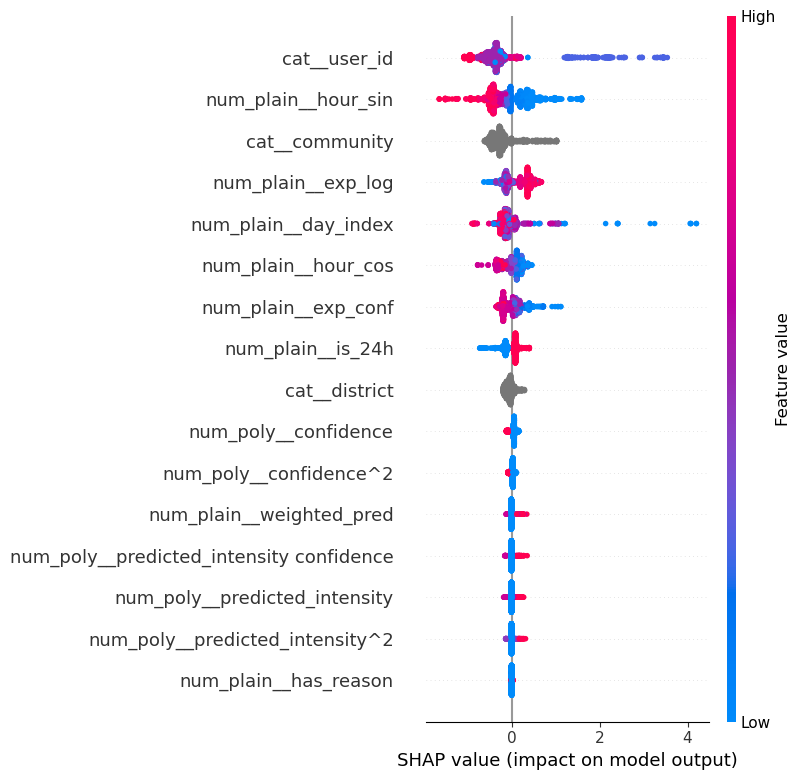

In [37]:
# Transform X with preprocessor
X_trans = pipe_ros.named_steps["prep"].transform(X)
feat_names = pipe_ros.named_steps["prep"].get_feature_names_out().astype(str)

# Subset for plotting
n_plot = min(2000, X_trans.shape[0])
X_plot = X_trans[:n_plot]

# pull trained CatBoost model from the wrapper
cb_model = pipe_ros.named_steps["clf"].model_

# SHAP explainer for CatBoost
explainer = shap.TreeExplainer(cb_model, feature_perturbation="tree_path_dependent")

# SHAP values
shap_values = explainer.shap_values(X_plot)

# Pick classes
class_idx = 3
if isinstance(shap_values, list):
    sv_class = shap_values[class_idx]
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    sv_class = shap_values[:, :, class_idx]
else:
    raise TypeError(f"Unexpected SHAP format: {type(shap_values)}, ndim={getattr(shap_values,'ndim',None)}")

# Global importance
if isinstance(shap_values, list):
    mean_abs_by_class = np.array([np.abs(sv).mean(axis=0) for sv in shap_values])
else:
    mean_abs_by_class = np.abs(shap_values).mean(axis=0).T
mean_abs_all = mean_abs_by_class.mean(axis=0)
top_idx = np.argsort(-mean_abs_all)[:30]
for i in top_idx:
    print(f"{feat_names[i]:40s}  mean|SHAP|={mean_abs_all[i]:.6f}")

# Plots
X_plot_dense = X_plot.toarray() if sp.issparse(X_plot) else X_plot
shap.summary_plot(sv_class, X_plot_dense, feature_names=feat_names, show=True)



# 🏁 Train on Full Data, Predict Test, and Conform to SampleSubmission


Check that I have the right pipeline set up

In [55]:
print("Pipe model type:", type(pipe.named_steps["clf"]))

missing_test = [c for c in all_cols if c not in test.columns]
print("Missing test features:", missing_test)   # should be []



Pipe model type: <class '__main__.CBCatAsLast'>
Missing test features: []


In [56]:
def conform_to_sample(sample_df, pred_df, id_col="ID"):
    out = sample_df[[id_col]].merge(pred_df, on=id_col, how="left")
    # Ensure exact columns/order
    missing = set(sample_df.columns) - set(out.columns)
    if missing:
        # allow the single-target fallback
        tgt = [c for c in sample_df.columns if c != id_col]
        pred_only = [c for c in pred_df.columns if c != id_col]
        if len(tgt) == 1 and len(pred_only) == 1:
            out[tgt[0]] = out[pred_only[0]]
        else:
            raise ValueError(f"Missing columns: {missing}")
    return out[sample_df.columns]

In [58]:
# build X_test with the exact training columns
X_test = test[all_cols].copy()
for c in cat_cols:
    X_test[c] = X_test[c].astype("category").astype("str")

# predict class indices and map to labels
inv_map = {0:"NORAIN", 1:"SMALLRAIN", 2:"MEDIUMRAIN", 3:"HEAVYRAIN"}
y_pred = pd.Series(pipe_ros.predict(X_test).astype(int)).map(inv_map)

# align to sample_sub ID order
submission = sample_sub[["ID"]].merge(
    pd.DataFrame({"ID": test["ID"].values, "Target": y_pred}),
    on="ID", how="left"
)

# 4) sanity checks and save
assert list(submission.columns) == ["ID", "Target"]
assert submission.shape[0] == sample_sub.shape[0]
assert submission["ID"].equals(sample_sub["ID"])
assert submission["Target"].notna().all(), "Found NaNs in predictions."

submission.to_csv("submission_cat.csv", index=False)
print("Saved submission_cat.csv")


Saved submission_cat.csv


In [ ]:
sub = pd.read_csv('./submission_cat.csv')
cls_pct = sub['Target'].value_counts()
cls_pct

Target
NORAIN        2509
MEDIUMRAIN     219
SMALLRAIN        4
Name: count, dtype: int64